In [1]:
import numpy as np
import json
import csv

# Risultati analisi linguistica con Profiling UD

I risultati delle analisi sono in un file csv separato da TAB (\t).
- La prima riga del file è l'intestazione: (Filename, n_sentences, n_tokens, tokens_per_sent, ..., subordinate_dist_5)
- Ogni riga rappresenta l'analisi di un documento: il primo campo contiene il nome del documento analizzato, gli altri contengono le features estratte

<!-- Il nome del file contiene informazioni sul documento:
- Split del dataset (training, test dei vari task)
- ID dell'utente
- **genere** dell'utente: M o F
- **topic** dei post dell'utente: anime, medicine-aesthetics, auto-moto, sports, smoke, metal-detecting, celebrities, enterntainment, technology, nature, bikes.
- **età** dell'utente: 0-19, 20-29, 30-39, 50-100

Esempio: 'training#588_F_SPORTS_20-29.conllu'
- Il documento fa parte del training set
- L'id dell'utente è 588
- L'utente è una femmina
- Il topic dei post è sport
- L'età dell'utente è nel range 20-29 -->


# Caricamento dataset

Costruiamo il dataset come dizionario di documenti, dove ad ogni id di documento si associano le labels e le features di Profiling UD

    dataset = {
        'training_1': {
            'gender': 'M',
            'age': '20-29',
            'topic': 'ANIME'
            'features': [feat1, feat2, ..., featN]
        }

        ...

        'test_20': {
            'gender': 'F',
            'age': '0-19',
            'topic': 'SPORTS'
            'features': [feat1, feat2, ..., featN]

        }

    }


Abbiamo già creato un dizionario con questo formato durante il preprocessing, rimane solamente da aggiugnere il campo "features".

In [2]:
profiling_output_path = 'data/Tag-it/profiling_output/linguistic_profiling.csv'
user_info_path = 'data/Tag-it/preprocessed_dataset/user_info.json'

In [3]:
def load_user_info(src_path):
    with open(src_path, 'r') as src_file:
        user_info = json.load(src_file)
    return user_info

In [4]:
user_info = load_user_info(user_info_path)

In [5]:
user_info;

In [6]:
def load_profiling_features(src_path, user_info):
    features_names = None
    dataset = user_info
    with open(src_path, 'r') as src_file:
        csv_reader = csv.reader(src_file, delimiter='\t')
        for row in csv_reader:
            if features_names is None: # la prima riga del csv contiene 'Filename' e tutti i nomi delle features
                features_names = row[1:]
            else:
                doc_id = row[0].split('/')[-1][:-len('.conllu')] # il primo elemento di ogni riga contiene il nome del file
                features = [float(el) for el in row[1:]] # dal secondo elemento in poi ci sono le features
                dataset[doc_id]['features'] = features
    return features_names, dataset

In [7]:
features_names, dataset = load_profiling_features(profiling_output_path, user_info)
del user_info # per risparmiare memoria

In [8]:
print(f'Numero features: {len(features_names)}')
print('\nLista features:')
print(features_names[:10])

Numero features: 142

Lista features:
['n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200', 'ttr_form_chunks_100', 'ttr_form_chunks_200', 'upos_dist_ADJ', 'upos_dist_ADP']


In [9]:
doc_id = 'training_1'
print(f'Primo documento, id {doc_id}')
for key, value in dataset[doc_id].items():
    print(f'{key}: ', value)

Primo documento, id training_1
topic:  ANIME
age:  20-29
gender:  M
split:  training
features:  [282.0, 5609.0, 19.890070921985817, 4.643816110659072, 0.71, 0.67, 0.73, 0.725, 5.188090568728828, 13.763594223569264, 6.20431449456231, 3.6191834551613478, 2.6564449991085755, 14.655018719914423, 0.2317703690497415, 16.81226600106971, 1.2836512747370297, 0.0, 4.885006239971474, 7.612765198787662, 12.355143519343912, 1.2836512747370297, 0.08914244963451595, 9.11035835264753, 0.2495988589766447, 0.5126118795768918, 2.6392961876832843, 3.812316715542522, 39.882697947214076, 53.665689149560116, 0.4484304932735426, 1.7937219730941705, 94.17040358744394, 3.587443946188341, 43.639921722113506, 3.522504892367906, 29.74559686888454, 23.091976516634052, 0.0, 0.0, 4.0358744394618835, 0.8968609865470852, 21.524663677130047, 4.932735426008969, 2.242152466367713, 66.3677130044843, 1.1363636363636365, 7.386363636363637, 6.25, 85.22727272727273, 4.790419161676646, 0.0, 85.62874251497006, 9.580838323353293,

## Divisione training set e test set

La divisione viene fatta guardando il campo **split** del documento.

In [10]:
def train_test_split(dataset, target_label):
    train_features, test_features = [], []
    train_labels, test_labels = [], []

    for doc_id in dataset:
        split = dataset[doc_id]['split']
        features = dataset[doc_id]['features']
        label = dataset[doc_id][target_label]
        if split == 'training':
            train_features.append(features)
            train_labels.append(label)
        else: # if split == 'test'
            test_features.append(features)
            test_labels.append(label)

    return train_features, train_labels, test_features, test_labels

In [11]:
target_label = 'topic'
train_features, train_labels, test_features, test_labels = train_test_split(dataset, target_label)

print('Documenti training set:', len(train_features), len(train_labels))
print('Documenti test set:', len(test_features), len(test_labels))

Documenti training set: 1109 1109
Documenti test set: 411 411


In [12]:
train_labels;

## Trasformiamo le nostre liste in matrici per usarle con scikit-learn
In realtà la maggior parte delle funzioni di scikit-learn convertono automaticamente le liste in matrici

In [13]:
X_train = np.array(train_features)
y_train = np.array(train_labels)
X_test = np.array(test_features)
y_test = np.array(test_labels)

In [14]:
X_train

array([[2.82000000e+02, 5.60900000e+03, 1.98900709e+01, ...,
        4.62184874e+00, 2.52100840e+00, 0.00000000e+00],
       [6.60000000e+01, 7.43000000e+02, 1.12575758e+01, ...,
        0.00000000e+00, 3.22580645e+00, 0.00000000e+00],
       [5.20000000e+01, 6.96000000e+02, 1.33846154e+01, ...,
        4.16666667e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.10000000e+01, 7.20000000e+02, 1.75609756e+01, ...,
        3.03030303e+00, 0.00000000e+00, 0.00000000e+00],
       [8.70000000e+01, 6.19000000e+02, 7.11494253e+00, ...,
        6.66666667e+00, 0.00000000e+00, 0.00000000e+00],
       [5.10000000e+01, 6.42000000e+02, 1.25882353e+01, ...,
        3.22580645e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(1109, 142))

## Normalizzazione
Prima di classificare dobbiamo normalizzre tutti i valori delle features.

Gli scaler più utlizzati sono lo lo **Standard Scaler** e il **Min-Max Scaler**

### Standard Scaler

Scala le features centrandole intorno a 0 e con varianza unitaria.

<br />

$
x_{scaled} = \frac{x-\mu}{\sigma}
$

<br />
 
 ### Min-Max scaler

Scala le features tra 0 e 1.

<br />

$
x_{scaled} = \frac{x-x_{min}}{x_{max} - x_{min}}
$

<br />

**NB 1**: La normalizzazione viene fatta per **colonne**!

**NB 2**: Il test set deve essere normalizzato con lo stesso scaler del training set

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
l = [[1,2,3],[4,5,6],[7,8,9]]
example_scaler = MinMaxScaler()
scaled_l = example_scaler.fit_transform(l)
scaled_l

array([[0. , 0. , 0. ],
       [0.5, 0.5, 0.5],
       [1. , 1. , 1. ]])

In [17]:
l = [[1,2,3],[4,5,6],[7,8,9]]
example_scaler = StandardScaler()
scaled_l = example_scaler.fit_transform(l)
scaled_l

array([[-1.22474487, -1.22474487, -1.22474487],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.22474487,  1.22474487,  1.22474487]])

In [18]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)

In [19]:
scaled_X_train

array([[0.56112224, 0.53610411, 0.05515349, ..., 0.15021008, 0.1512605 ,
        0.        ],
       [0.12825651, 0.02539882, 0.02994913, ..., 0.        , 0.19354839,
        0.        ],
       [0.1002004 , 0.02046599, 0.03615946, ..., 0.13541667, 0.        ,
        0.        ],
       ...,
       [0.07815631, 0.02298489, 0.04835321, ..., 0.09848485, 0.        ,
        0.        ],
       [0.17034068, 0.01238455, 0.01785385, ..., 0.21666667, 0.        ,
        0.        ],
       [0.09819639, 0.01479849, 0.03383426, ..., 0.10483871, 0.        ,
        0.        ]], shape=(1109, 142))

# Classificazione

Addestriamo un Support Vector Classfier Lineare

Parametro **dual**:
    dual (bool, default=True)
    Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.


In [20]:
from sklearn.svm import LinearSVC

In [21]:
svc = LinearSVC(dual=False, max_iter=1000)
svc.fit(scaled_X_train, y_train)

LinearSVC(dual=False)

# K-fold cross-validation
### Come posso farmi un'idea di come funziona il mio modello se non ho il test set?

Si può utilizzare anche per fare model selection  

![Cross validation](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier

In [23]:
splitter = KFold(n_splits=10, random_state=42, shuffle=True)
folds = list(splitter.split(X_train))

for i in range(len(folds)):
    print(len(folds[i][0]), len(folds[i][1]))

998 111
998 111
998 111
998 111
998 111
998 111
998 111
998 111
998 111
999 110


In [24]:
all_y_true = []
all_y_pred = []

for i, (train_ids, test_ids) in enumerate(splitter.split(X_train)):
#for i in range(len(folds)):
 #   train_ids = folds[i][0]
  #  test_ids = folds[i][1]
    

    fold_X_train = X_train[train_ids]
    fold_y_train = y_train[train_ids]

    fold_X_test = X_train[test_ids]
    fold_y_test = y_train[test_ids]

    # Scaliamo le features
    scaler = MinMaxScaler()
    fold_X_train = scaler.fit_transform(fold_X_train)
    fold_X_test = scaler.transform(fold_X_test)

    kfold_svc = LinearSVC(dual=False, max_iter=10000)
    kfold_svc.fit(fold_X_train, fold_y_train)
    fold_y_pred = kfold_svc.predict(fold_X_test)
    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

    dummy_clf = DummyClassifier(strategy="most_frequent")   # dummy classifier viene utilizzato per avere una baseline
    dummy_clf.fit(fold_X_train, fold_y_train)
    dummy_score = dummy_clf.score(fold_X_test, fold_y_test)
    
    all_y_true += fold_y_test.tolist()
    all_y_pred += fold_y_pred.tolist()
    print(f"Accuracy fold {i+1}: {fold_accuracy}, baseline: {dummy_score}")
print(f"\nOverall accuracy: {accuracy_score(all_y_true, all_y_pred)}")

Accuracy fold 1: 0.5495495495495496, baseline: 0.34234234234234234
Accuracy fold 2: 0.4594594594594595, baseline: 0.26126126126126126
Accuracy fold 3: 0.5045045045045045, baseline: 0.3153153153153153
Accuracy fold 4: 0.4774774774774775, baseline: 0.27927927927927926
Accuracy fold 5: 0.43243243243243246, baseline: 0.32432432432432434
Accuracy fold 6: 0.5135135135135135, baseline: 0.25225225225225223
Accuracy fold 7: 0.4144144144144144, baseline: 0.22522522522522523
Accuracy fold 8: 0.5405405405405406, baseline: 0.26126126126126126
Accuracy fold 9: 0.3783783783783784, baseline: 0.1891891891891892
Accuracy fold 10: 0.42727272727272725, baseline: 0.2545454545454545

Overall accuracy: 0.4697926059513075


## Come capiamo se il modello è buono?
Facciamo il confronto con una baseline

In [25]:
baseline_classifier = DummyClassifier(strategy="uniform")

In [26]:
from sklearn.model_selection import cross_val_score
svc = LinearSVC(dual=False, max_iter=10000)
# scores = cross_val_score(svc, scaled_X_train, y_train, cv=10)
# scores = cross_val_score(svc, scaled_X_train, y_train, cv=splitter)
scores = cross_val_score(svc, scaled_X_train, y_train, cv=10, scoring='f1_macro')
scores

/home/luca/Workspace/linguistica_computazionale_2/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


array([0.26795518, 0.30549703, 0.21876425, 0.18968849, 0.2637711 ,
       0.18542584, 0.18113334, 0.21990565, 0.20357279, 0.27536118])

## Metriche di valutazione più informative

In [27]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [28]:
print(classification_report(all_y_true, all_y_pred, zero_division=0)) # , output_dict=True

                     precision    recall  f1-score   support

              ANIME       0.51      0.63      0.57       247
          AUTO-MOTO       0.41      0.47      0.44       226
              BIKES       0.25      0.04      0.06        27
        CELEBRITIES       0.58      0.39      0.46        49
      ENTERTAINMENT       0.00      0.00      0.00        32
MEDICINE-AESTHETICS       0.00      0.00      0.00        29
    METAL-DETECTING       0.28      0.19      0.23        78
             NATURE       0.11      0.03      0.04        36
              SMOKE       0.44      0.34      0.39        79
             SPORTS       0.51      0.65      0.58       300
         TECHNOLOGY       0.00      0.00      0.00         6

           accuracy                           0.47      1109
          macro avg       0.28      0.25      0.25      1109
       weighted avg       0.42      0.47      0.44      1109



In [29]:
confusion_matrix(all_y_true, all_y_pred)

array([[155,  27,   1,   6,   1,   0,   2,   3,   4,  48,   0],
       [ 39, 107,   1,   0,   1,   1,  14,   1,  10,  52,   0],
       [  5,   9,   1,   0,   0,   1,   3,   0,   0,   8,   0],
       [ 11,   3,   0,  19,   0,   0,   2,   0,   0,  14,   0],
       [  6,   7,   0,   0,   0,   0,   4,   0,   2,  13,   0],
       [  5,  15,   0,   0,   0,   0,   0,   1,   2,   6,   0],
       [ 14,  24,   1,   0,   0,   0,  15,   0,   6,  18,   0],
       [ 11,  10,   0,   1,   0,   0,   2,   1,   1,  10,   0],
       [ 14,  14,   0,   0,   0,   2,   5,   2,  27,  15,   0],
       [ 40,  38,   0,   7,   2,   0,   7,   1,   9, 196,   0],
       [  1,   4,   0,   0,   0,   0,   0,   0,   0,   1,   0]])

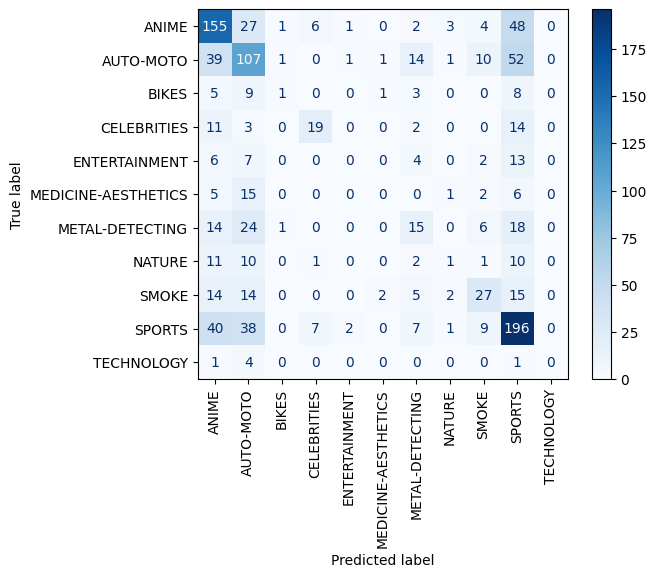

In [30]:
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, xticks_rotation='vertical', cmap='Blues');

# Test del modello scelto

Ricordiamoci di scalare il test set

In [31]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [32]:
svc = LinearSVC(dual=False, max_iter=10000)
svc.fit(scaled_X_train, train_labels)

LinearSVC(dual=False, max_iter=10000)

In [33]:
test_predictions = svc.predict(scaled_X_test)

In [34]:
test_predictions[:10]

array(['CELEBRITIES', 'ANIME', 'ANIME', 'ANIME', 'AUTO-MOTO', 'ANIME',
       'SPORTS', 'SMOKE', 'NATURE', 'SMOKE'], dtype='<U19')

In [35]:
print(classification_report(test_labels, test_predictions, zero_division=0))#, output_dict=True))

                     precision    recall  f1-score   support

              ANIME       0.50      0.62      0.56        97
          AUTO-MOTO       0.41      0.54      0.46        76
              BIKES       0.00      0.00      0.00        12
        CELEBRITIES       0.52      0.50      0.51        22
      ENTERTAINMENT       0.00      0.00      0.00         9
MEDICINE-AESTHETICS       0.00      0.00      0.00        16
    METAL-DETECTING       0.45      0.35      0.39        26
             NATURE       0.00      0.00      0.00        11
              SMOKE       0.38      0.20      0.26        30
             SPORTS       0.55      0.67      0.60       103
         TECHNOLOGY       0.00      0.00      0.00         9

           accuracy                           0.48       411
          macro avg       0.26      0.26      0.25       411
       weighted avg       0.42      0.48      0.44       411



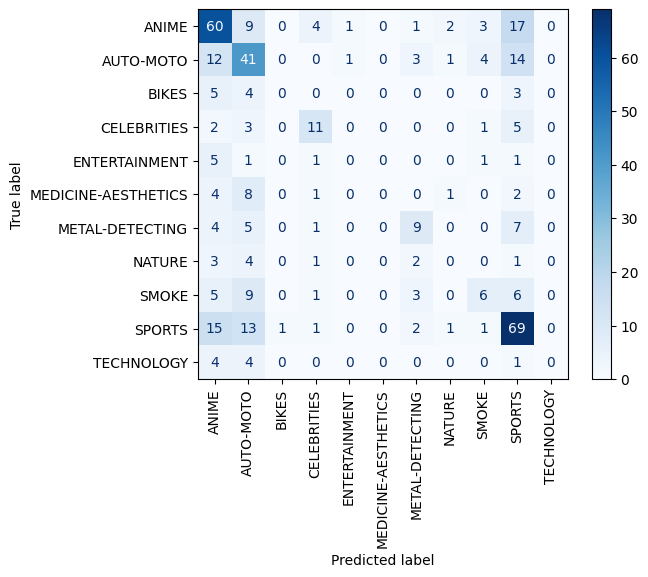

In [36]:
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues');

# Confrontiamo con la baseline

In [37]:
baseline_classifier = DummyClassifier(strategy="uniform")
baseline_classifier.fit(X_train, train_labels)
baseline_test_predictions = baseline_classifier.predict(X_test)
print(classification_report(test_labels, baseline_test_predictions, zero_division=0))

                     precision    recall  f1-score   support

              ANIME       0.13      0.04      0.06        97
          AUTO-MOTO       0.10      0.04      0.06        76
              BIKES       0.03      0.08      0.04        12
        CELEBRITIES       0.03      0.05      0.03        22
      ENTERTAINMENT       0.05      0.22      0.08         9
MEDICINE-AESTHETICS       0.03      0.06      0.04        16
    METAL-DETECTING       0.05      0.08      0.06        26
             NATURE       0.03      0.09      0.04        11
              SMOKE       0.13      0.20      0.16        30
             SPORTS       0.16      0.05      0.07       103
         TECHNOLOGY       0.04      0.22      0.07         9

           accuracy                           0.07       411
          macro avg       0.07      0.10      0.07       411
       weighted avg       0.11      0.07      0.07       411



## Prediction scores

In [44]:
test_sample = scaled_X_test[0].reshape(1, -1)
print('Classe predetta:', svc.predict(test_sample)[0])
print('Scores:')
prediction_scores = svc.decision_function(test_sample)[0]
for label, score in zip(svc.classes_, prediction_scores):
    print(label, score)

Classe predetta: CELEBRITIES
Scores:
ANIME -1.4472765684774191
AUTO-MOTO 0.20708252569236518
BIKES -1.0361168203550628
CELEBRITIES 0.45788876241105725
ENTERTAINMENT -1.1353718532930352
MEDICINE-AESTHETICS -1.5179162948345981
METAL-DETECTING -1.4361485554347226
NATURE -0.9235005482071557
SMOKE -2.5778400742612764
SPORTS -0.24630166446422858
TECHNOLOGY -2.0341796585837355


# Feature importance

Per ogni classe, ls SVC ha una diversa feature importance

In [39]:
svc.classes_

array(['ANIME', 'AUTO-MOTO', 'BIKES', 'CELEBRITIES', 'ENTERTAINMENT',
       'MEDICINE-AESTHETICS', 'METAL-DETECTING', 'NATURE', 'SMOKE',
       'SPORTS', 'TECHNOLOGY'], dtype='<U19')

In [40]:
coefs = svc.coef_ # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)
coefs.shape

(11, 142)

Feature importance classe AUTO-MOTO


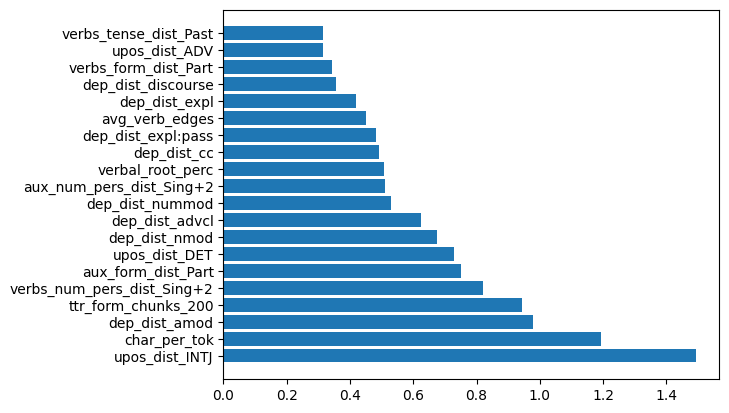

In [41]:
import matplotlib.pyplot as plt
idx = 1
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 20
print(f'Feature importance classe {svc.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.show()